# DNN - Assignment 2
#### Kamil Tokarski kt361223

In [2]:
Assignmentimport torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as tr_f

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np


BATCH_SIZE = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
DATA_PATH = './data/'
TRAIN_PATH = DATA_PATH + 'train/'
TEST_PATH = DATA_PATH + 'test/'
MASK_FILE = "mask.npy"
IMAGE_FILE = "image.npy"


AUG_TRANSFORMS = (
    lambda x: x, 
    lambda x: x.rotate(90), 
    lambda x: x.rotate(270), 
    lambda x: tr_f.hflip(x),
    lambda x: x.rotate(180),
)


CONTR_TRANSFORMS = (
    lambda x: x, 
    lambda x: x.rotate(-90), 
    lambda x: x.rotate(-270), 
    lambda x: tr_f.hflip(x),
    lambda x: x.rotate(-180),
)


NO_TRANS = len(CONTR_TRANSFORMS)


image = np.load(TRAIN_PATH + IMAGE_FILE)
mask = np.load(TRAIN_PATH + MASK_FILE)
test_image = np.load(TEST_PATH + IMAGE_FILE)
test_mask = np.load(TEST_PATH + MASK_FILE)


from_pil_transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


def augmented(images, masks):
    """
    Applies transform to given batch of images keeping the relative order of images
    [i1, i2] -> [t1(i1), .. tk(i1), t1(i2) .. tk(ik)]
    """
    assert(images.shape[0] == masks.shape[0])
    a_images = []
    a_masks = []
    for i in range(images.shape[0]):
        image = tr_f.to_pil_image(images[i])
        mask = tr_f.to_pil_image(masks[i])
        for to, d in zip((a_images, a_masks), (image, mask)):
            for t in AUG_TRANSFORMS:
                to.append(t(d))
    return (
        torch.stack(list(map(lambda m: from_pil_transform(tr_f.to_tensor(m)), a_images))),
        torch.stack(list(map(lambda m: tr_f.to_tensor(m), a_masks))),
    )


def contract_select_id(ts):
    """
    Given augmented batch returns only images transformed with identity
    """
    count = ts.shape[0]
    n = NO_TRANS
    assert(count % n == 0)
    return torch.stack([
        ts[n * instance_i] 
        for instance_i in range(count // n)
    ])


def contract_by_averaging(masks):  # i.e. reverse augmentation, used for self-augmentation
    """
    Given masks for augmented batch returns mask avaraged for each original instance
    over its all transformed copies
    """
    count = masks.shape[0]
    n = NO_TRANS
    assert(count % n == 0)
    c_masks = []
    for instance_i in range(count // n):
        i = n * instance_i
        instance_masks = torch.stack([
            tr_f.to_tensor(t(tr_f.to_pil_image(masks[j])))
            for j, t in enumerate(CONTR_TRANSFORMS, start=i)
        ])
        instance_mask = instance_masks.mean(0)
        c_masks.append(instance_mask)
    return torch.stack(c_masks)


class TransformDataset(data.TensorDataset):
    
    """
    Simple tensor dataset. I planned to augment batches on the fly, but as the whole batch 
    fitted into memory I dropped the idea
    """

    def __init__(self, images, masks, transform_image=None, transform_mask=None):
        
        images = self.transform(images, transform_image)
        masks = self.transform(masks, transform_mask)
        super(TransformDataset, self).__init__(images, masks)
    
    @classmethod
    def transform(cls, ds, transformation):
        
        if torch.is_tensor(ds) and transformation is None:
            return ds
        
        n = ds.shape[0]
        
        if not torch.is_tensor(ds):
            ds = [tr_f.to_tensor(ds[i]) for i in range(n)]

        if transformation is not None:
            ds = [transformation(ds[i]) for i in range(n)]
                    
        return torch.stack(ds)


def create_dataset(images, masks, batch_size=BATCH_SIZE, shuffle=True, augment=True, drop_last=True):
    if augment:
        images, masks = augmented(images, masks)
    dataset = TransformDataset(
        images, masks, transform_image=None if augment else from_pil_transform
    )
    loader = data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle,
        drop_last=drop_last,
    )
    return dataset, loader


def plot_masked_np(samples):
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.05, hspace=0.05)

    for i, (img, mask) in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow((img.transpose(1, 2, 0) + 1) / 2)
        plt.imshow(mask.reshape(mask.shape[1:3]), cmap='seismic', alpha=0.6)

    return fig


def plot_tensor(images, masks):
    return plot_masked_np((images[i].cpu().numpy(), masks[i].cpu().numpy()) for i in range(9))

In [4]:
import functools
import operator

THRESHOLD = 0.5

def mask_threshold(mask, threshold=THRESHOLD):
    meets_cond = mask > threshold
    mask = mask.clone()
    mask[meets_cond] = 1.
    mask[meets_cond ^ torch.ones_like(meets_cond)] = 0.
    return mask


def pixel_stats(pred_mask, target):
    dims = pred_mask.dim()
    assert(dims > 3)
    dims = tuple(range(1, dims))
    
    pred_mask = pred_mask == 1.
    target = target == 1.
    
    conj = pred_mask & target
    disj = pred_mask | target
    tp = torch.sum(conj, dims)
    tp_fp_fn = torch.sum(disj, dims)
    tn = torch.sum((disj ^ torch.ones_like(disj)), dims)
    tn_tp_fp_fn = functools.reduce(operator.mul, target.shape[1:])
    tp_fn = torch.sum(target, dims)
    tp_fp = torch.sum(pred_mask, dims)
    
    acc = (tp.float() + tn.float()) / tn_tp_fp_fn
    iou = tp.float() / tp_fp_fn.float()
    recall = tp.float() / tp_fn.float()
    prec = tp.float() / tp_fp.float()
    
    return torch.stack([acc, iou, recall, prec])

In [5]:
class EvalNet(object):
    
    def __init__(self, net):
        self.net = net
        
    def __enter__(self):
        self.net.eval()
        torch.set_grad_enabled(False)
        return self.net
    
    def __exit__(self, type, value, traceback):
        torch.set_grad_enabled(True)
        self.net.train()    

        
class TestInfo(object):
    
    def __init__(self):
        _, self.test_loader = create_dataset(test_image, test_mask, 9 * NO_TRANS, shuffle=False,)
        self.test_loader_en = enumerate(self.test_loader)

    def print_test_output(self, net, epoch=None, i=None, save_to_file=True, threshold=0.5):
        assert(not save_to_file or (epoch is not None and i is not None))
        try:
            
            with EvalNet(net):
                _, (image, mask_targ) = next(self.test_loader_en)
                image = image.to(device)
                mask_targ = mask_targ.to(device)
                mask_pred_ = net(image)
                print(image.max(), image.min())
                
                print('test entropy', nn.functional.binary_cross_entropy(mask_pred_, mask_targ))
                c_image = contract_select_id(image.cpu())
                c_mask_target = contract_select_id(mask_targ.cpu())
                c_mask_pred_ = contract_by_averaging(mask_pred_.cpu())
                c_mask_pred = mask_threshold(c_mask_pred_, threshold)
                
                print('test', pixel_stats(c_mask_pred, c_mask_target).mean(1))
                for img, mask, name in [(c_image, c_mask_target, 't'), (c_image, c_mask_pred, 'p')]:
                    fig = plot_tensor(img, mask)
                    if save_to_file:
                        plt.savefig('outmask/{}_{}_{}.png'.format(epoch, str(i).zfill(3), name), bbox_inches='tight')
                        plt.close(fig)
                if not save_to_file:
                    for img, mask in [(image[(9 * i):(9 * (i + 1))], mask_pred_[(9 * i):(9 * (i + 1))],) for i in range(NO_TRANS)]:
                        fig = plot_tensor(img, mask)

        except StopIteration:
            self.test_loader_en = enumerate(self.test_loader)
            print('test reiterate')


test_info = TestInfo()

## Architecture

Implementation of *UNet* with encoder part consting of 6 units, each of them made of two conv (3x3, stride=1, padding='same') layers followed by maxpool (5 outer layers 2x2 with stride 2 and the last one 4x4 stride 4). Last maxpool is bigger so that encoding part yeilds 1x1 channels after last encoding unit without adding 7th unit to the encoder (which seemed to be impossible to process in reasonable time on my home computer).

Encoding layer is followed by similar convolution unit working on 1x1 channels (so its sort of dense layer simply).

Then there is decoder part closely coresponding to the encoder part: each decoding unit is fed with concatentation of upscaled output of the previous one and output of the corresponding encoder unit. As for upscaling, I've tested both max unpooling and tranposed convolutions - there seemed to be no difference in training error so I sticked to transposed convolutions that don't require keeping record of max locations from encoder.


In [6]:
class EncConv(nn.Module):
    
    def __init__(self, seq, p_kernel=2, p_stride=2):
        super(EncConv, self).__init__()
        
        self.pool = nn.MaxPool2d(p_kernel, p_stride, return_indices=True)
        self.seq = seq
    
    def forward(self, x, *args, **kwargs):
        x = self.seq(x)
        return (*self.pool(x), x.shape, x)


def conv(c_in, c_out, kernel=3, padding=0):
    return [
        nn.Conv2d(c_in, c_out, kernel, padding=padding, bias=False),
        nn.BatchNorm2d(c_out),
        nn.ReLU(),
        nn.Conv2d(c_out, c_out, kernel, padding=padding, bias=False),
        nn.BatchNorm2d(c_out),
        nn.ReLU(),
    ]


class DecConv(nn.Module):
    
    def __init__(self, c_in, c_out, kernel=3, padding=0, p_kernel=2, p_padding=1, p_stride=2, dropout=0.1):
        super(DecConv, self).__init__()
        
        self.convt = nn.ConvTranspose2d(
            c_in // 2, c_in // 2,
            kernel_size=p_kernel,
            stride=p_stride,
            padding=p_padding,
        )
        self.dropout = nn.Dropout2d(dropout)
        self.seq = nn.Sequential(*conv(c_in, c_out, kernel, padding))

    
    def forward(self, x, *args, **kwargs):
        conn = kwargs.pop('skip_conn')
        x = self.convt(x, *args, **kwargs)
        x = torch.cat((x, conn), 1)
        x = self.dropout(x)
        return self.seq(x)
        


class UNet(nn.Module):
    
    def __init__(self):
        super(UNet, self).__init__()
        
        self.enc_convs = [
            EncConv(nn.Sequential(*conv(3, 64, 3, 1))),  # 64
            EncConv(nn.Sequential(*conv(64, 96, 3, 1))),  # 32
            EncConv(nn.Sequential(*conv(96, 160, 3, 1))),  # 16
            EncConv(nn.Sequential(*conv(160, 288, 3, 1))),  # 8
            EncConv(nn.Sequential(*conv(288, 384, 3, 1))),  # 4
            EncConv(nn.Sequential(*conv(384, 512, 3, 1)), 4, 4),  # 1

        ]
        for i, enc in enumerate(self.enc_convs):
            setattr(self, 'e{}'.format(i), enc)
        
        self.conv = nn.Sequential(*conv(512, 512, 3, 1))
            
        self.dec_convs = [
            DecConv(1024, 384, 3, 1, 4, 0, 1, dropout=0.5),  # 4
            DecConv(768, 288, 3, 1, 4, dropout=0.2),  # 8
            DecConv(576, 160, 3, 1, 4, dropout=0.1),  # 16
            DecConv(320, 96, 3, 1, 4, dropout=0.05),  # 32
            DecConv(192, 64, 3, 1, 4, dropout=0),  # 64
            DecConv(128, 3, 3, 1, 4, dropout=0),  # 128
        ]
        for i, dec in enumerate(self.dec_convs):
            setattr(self, 'd{}'.format(i), dec)
        
        self.final_layer = nn.Sequential(
            nn.Conv2d(3, 1, 3, padding=1, bias=True),
            nn.Sigmoid(),
        )
        
        
    def forward(self, x):
        outputs = []
        for enc in self.enc_convs:
            x, inds, shape, hr_x = enc(x)
            outputs.append(hr_x)
        x = self.conv(x)
        for dec, conn in zip(self.dec_convs, reversed(outputs)):
            x = dec(x, skip_conn=conn)
        return self.final_layer(x)
        


In [7]:
MODEL_SAVE_PATH = "./model/{}{}.pth"
LOOP_STATS = 20
EPOCHS_NO = 15


def train(net, name, loss_fun, optimizer, train_loader, resume_epoch=0):

    if resume_epoch > 0:
        net.load_state_dict(torch.load(
            MODEL_SAVE_PATH.format(name, resume_epoch - 1), map_location=device
        ))
        
    j = 0
    for epoch in range(resume_epoch, EPOCHS_NO):  # loop over the dataset multiple times
        running_loss = 0.
        running_stats = torch.zeros(4).to(device)
        
        for i, (image, mask) in enumerate(train_loader, 0):
            image = image.to(device)
            mask = mask.to(device)
            
            optimizer.zero_grad()
            
            outputs = net(image)
            loss = loss_fun(outputs, mask)
            binary_pred = mask_threshold(outputs)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_stats += pixel_stats(binary_pred, mask).mean(1)
            
            if i == 0 and epoch == 0:
                test_info.print_test_output(net, epoch, j)
                j += 1
                print('[%d, %5d] loss: %.3f' % (
                    epoch + 1, i + 1,
                    running_loss
                ))
                print(running_stats)
            elif i % LOOP_STATS == LOOP_STATS - 1:
                test_info.print_test_output(net, epoch, j)
                j += 1
                print('[%d, %5d] loss: %.3f' % (
                    epoch + 1, i + 1,
                    running_loss / LOOP_STATS
                ))
                print(running_stats / LOOP_STATS)
                running_loss = 0.0
                running_stats = torch.zeros(4).to(device)
        
        torch.save(net.state_dict(), MODEL_SAVE_PATH.format(name, epoch))

    print('Finished Training')

In [8]:
net = UNet()
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
loss_function = nn.BCELoss()
_, loader = create_dataset(image, mask)

train(net, 'plain', loss_function, optimizer, loader, resume_epoch=15)

Finished Training


## Training and augmentation

I've trained the network for 9 epochs with 20 batch size and 1e-3 learning rate (decreased to 1e-4 around 5th epoch), and weight_decay at 1e-4. The original dataset is augmented with rotations by 90, 180 and 270 degress and also with horizontal flip.

In the testing process I use self-augmentation process as described in the problem statement. You can see below example ground truth, prediction on the test dataset samples and predictions for each of the augmented instances.

*Side note: In the implemented self-augmenation outputs (i.e probabilites for each pixel) for the same image under different transformations are averaged and then threshold is applied. Might be worth to check is first application of the thresholds for each transformed copy and then "voting" would yield different results. But I didn't manage to test that before the deadline.*

tensor(1.) tensor(-1.)
test entropy tensor(0.3188)
test tensor([0.9114, 0.8240, 0.8472, 0.9164])


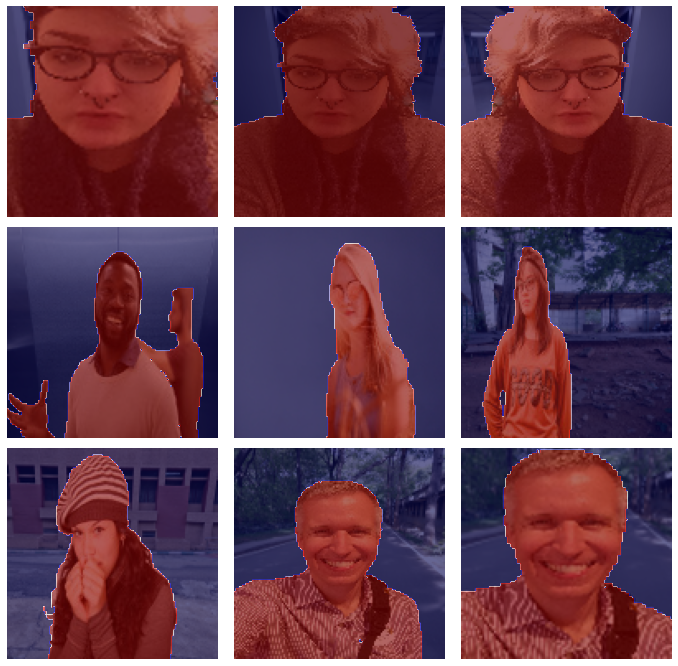

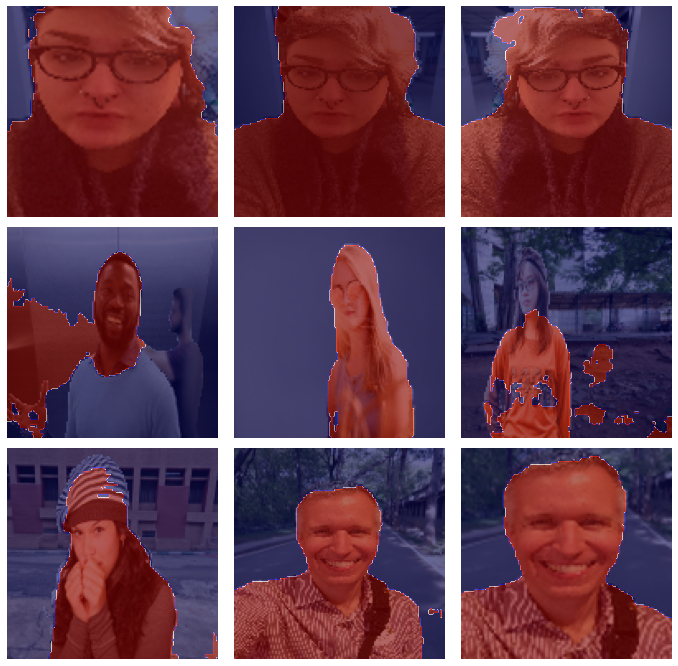

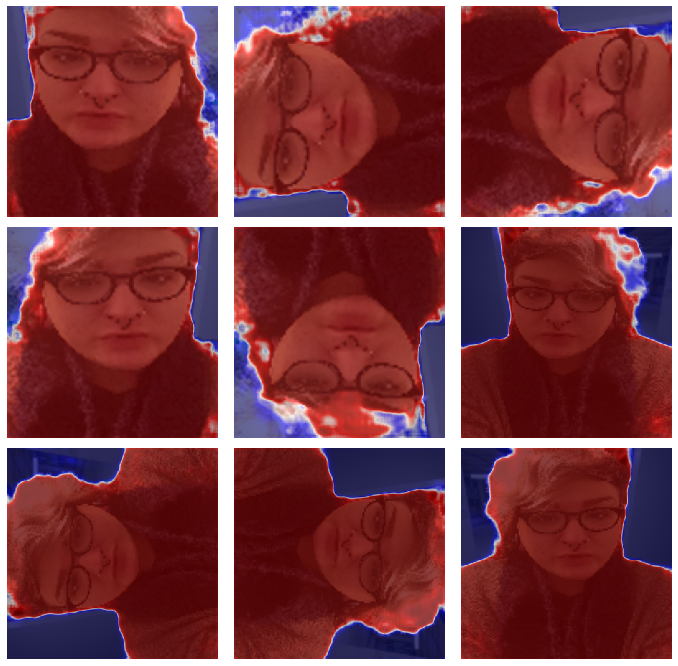

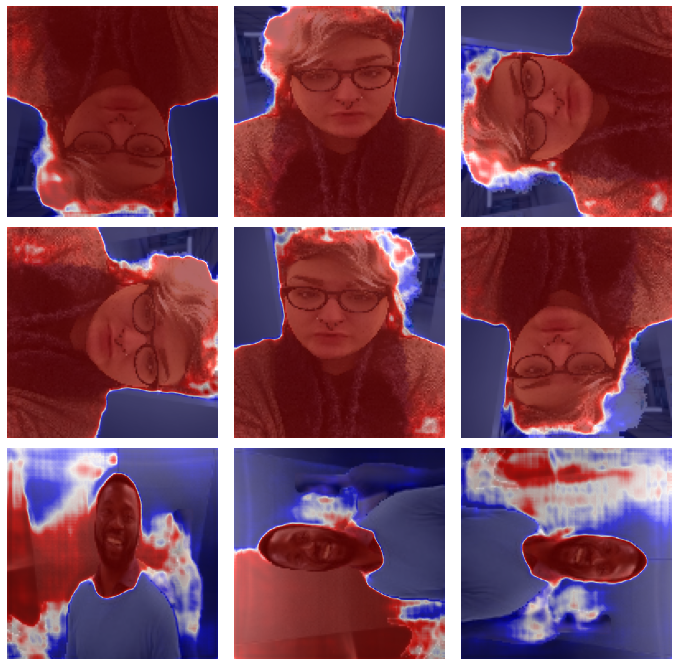

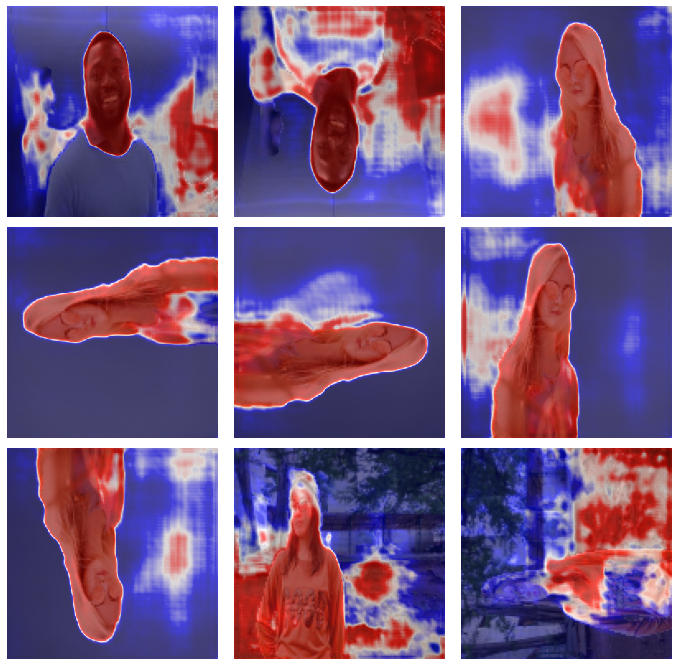

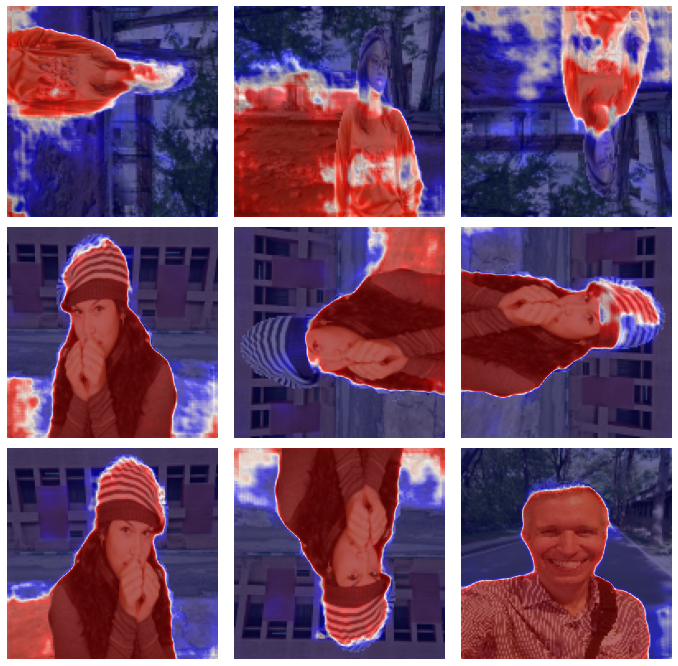

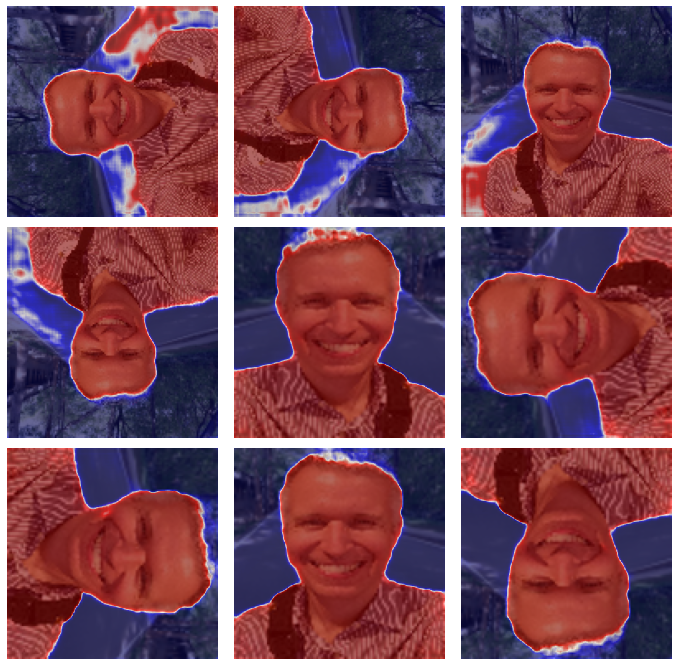

In [9]:
test_info = TestInfo()

test_info.print_test_output(net, save_to_file=False, threshold=0.6)

## Model statistics:

In [12]:
def set_statistics(image, mask, net, sample_size, threshold):
    with EvalNet(net):
        _, loader = create_dataset(image, mask, sample_size * NO_TRANS, shuffle=False,)
        _, (image_sample, mask_sample) = next(enumerate(loader))

        mask_pred_ = net(image_sample)
        
        c_mask_target = contract_select_id(mask_sample)
        c_mask_pred_ = contract_by_averaging(mask_pred_)
        c_mask_pred = mask_threshold(c_mask_pred_, threshold)

        bce = nn.functional.binary_cross_entropy(mask_pred_, mask_sample)
        acc_mean = pixel_stats(c_mask_pred, c_mask_target).mean(1)
        acc_max = pixel_stats(c_mask_pred, c_mask_target).max(1)
        acc_min = pixel_stats(c_mask_pred, c_mask_target).min(1)
    return bce, acc_mean, acc_max, acc_min, c_mask_pred_

First lets decide on threshold used in further analysis

In [10]:
# # would be great to cv that but it would take ages so just using validation set
# ms = []
# lp = np.linspace(0.1, 0.9, 9)
# for t in [t for t in lp]:
#     _, m, _, _, _ = set_statistics(test_image, test_mask, net, 20, t)
#     ms.append(m[0])

# plt.plot(lp, ms, color='orange')

Clearly threshold 0.4 is a winner.

Now let's look at the (estimated) overall performance on training set and test set.

In [11]:
tr_bce, tr_acc_mean, tr_acc_max, tr_acc_min, tr_c_mask_pred_ = set_statistics(image, mask, net, 100, 0.6)

#### Training stats
* binary cross entropy (loss) 0.1081
* average accuracy 0.9609 (best 0.9944, worst 0.7814)
* intersection over union: 0.9351 (best 0.9923, worst 0.7250)
* recall: 0.9855 (0.9997, 0.9383)
* precision: 0.9383 (0.9970, 0.7253)

In [12]:
ts_bce, ts_acc_mean, ts_acc_max, ts_acc_min, ts_c_mask_pred_ = set_statistics(test_image, test_mask, net, 100, 0.6)

#### Test stats
* binary cross entropy (loss) 0.2127
* average accuracy 0.9220 (best 0.9910, worst 0.6300)
* intersection over union: 0.8691 (best 0.9890, worst 0.2073)
* recall: 0.9548 (1.0000, 0.3441)
* precision: 0.9005 (0.9984, 0.3428)


### Best cases
Let's have a look on examples when net performed remarkably well on respectively train and test sets.

In [14]:
def plot_ex(img, msk):
    plt.imshow(tr_f.to_pil_image(img))
    plt.imshow(tr_f.to_pil_image(msk), cmap='seismic', alpha=0.7)

# print(tr_bce, tr_acc_mean, tr_acc_max, tr_acc_min)
# print(ts_bce, ts_acc_mean, ts_acc_max, ts_acc_min)

In [15]:
# training set with high accuracy
plot_ex(image[34], tr_c_mask_pred_[34])

NameError: name 'tr_c_mask_pred_' is not defined

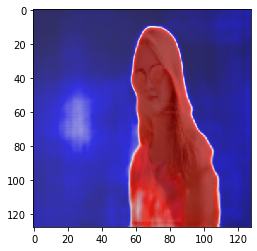

In [88]:
# test set with high accuracy
plot_ex(test_image[4], ts_c_mask_pred_[4])

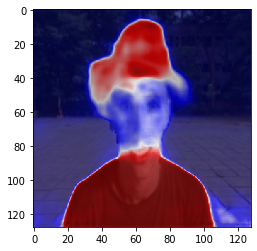

In [89]:
# test set example with 100% recall (but not so great precision)
plot_ex(test_image[42], ts_c_mask_pred_[42])

### Worst examples

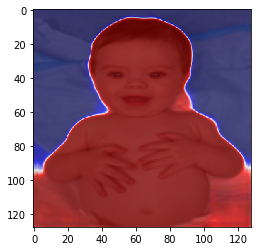

In [90]:
# training set with low accuracy
plot_ex(image[31], tr_c_mask_pred_[31])

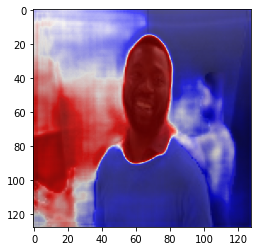

In [91]:
# test set with low accuracy
plot_ex(test_image[3], ts_c_mask_pred_[3])

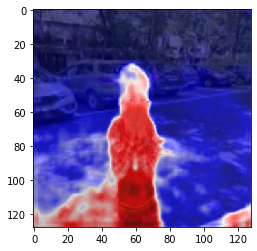

In [92]:
# test set with low recall/sensitivity/iou
plot_ex(test_image[53], ts_c_mask_pred_[53])

It seems that complicated backgrounds are troublesome for the net (as well as deciding were particulary fluffy haircut ends and background starts). 

### Entropy vs classification
It seems quite straightforward by definition of bce that entropy and classification as it is performed here must be closesly coupled (lower bce, better accuracy). To see it visually let's observe this stats from one of the runs from training process (for a bit different model then eventually, but this are stats I saved).


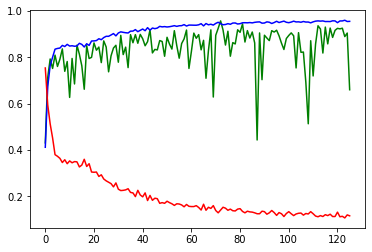

In [93]:
import json
stats = json.loads('{"tst_acc_mxp": [0.4309, 0.7136, 0.7929, 0.752, 0.8094, 0.7606, 0.7919, 0.8364, 0.7396, 0.7819, 0.627, 0.7951, 0.6851, 0.8525, 0.8133, 0.7634, 0.6622, 0.8505, 0.7949, 0.7999, 0.8621, 0.8307, 0.8443, 0.7772, 0.8708, 0.8446, 0.7375, 0.8065, 0.8401, 0.8519, 0.7789, 0.8946, 0.8118, 0.8439, 0.7556, 0.8977, 0.8629, 0.8978, 0.8607, 0.899, 0.8802, 0.8499, 0.8675, 0.9181, 0.819, 0.8341, 0.8319, 0.8723, 0.8683, 0.8046, 0.8864, 0.8572, 0.8356, 0.9149, 0.8502, 0.7962, 0.8595, 0.8795, 0.9176, 0.752, 0.825, 0.9045, 0.8821, 0.898, 0.8323, 0.8733, 0.7096, 0.8287, 0.9185, 0.6287, 0.895, 0.925, 0.9572, 0.9179, 0.853, 0.9126, 0.8048, 0.8635, 0.8577, 0.9187, 0.9078, 0.9443, 0.866, 0.9153, 0.8832, 0.9092, 0.8619, 0.4433, 0.9052, 0.7035, 0.8953, 0.8833, 0.8721, 0.9149, 0.9091, 0.9169, 0.8928, 0.8612, 0.8338, 0.8811, 0.8944, 0.9054, 0.8928, 0.7542, 0.9064, 0.8216, 0.8227, 0.6926, 0.5132, 0.8716, 0.7196, 0.8572, 0.9362, 0.9222, 0.8185, 0.9305, 0.858, 0.9263, 0.8859, 0.9165, 0.925, 0.9228, 0.9256, 0.8895, 0.9047, 0.6601], "tr_acc_mxp": [0.4119, 0.674, 0.7646, 0.8006, 0.8352, 0.8383, 0.8399, 0.8514, 0.8466, 0.8559, 0.8486, 0.8499, 0.8478, 0.8491, 0.8605, 0.8558, 0.8446, 0.8586, 0.8514, 0.8705, 0.8708, 0.8723, 0.8802, 0.8761, 0.8852, 0.8907, 0.8907, 0.8964, 0.9025, 0.8926, 0.905, 0.9099, 0.9078, 0.9061, 0.905, 0.9128, 0.9132, 0.9196, 0.9107, 0.9166, 0.9221, 0.9148, 0.928, 0.9172, 0.9264, 0.9237, 0.9262, 0.9336, 0.9314, 0.9326, 0.9309, 0.9321, 0.9341, 0.9365, 0.9336, 0.9362, 0.9366, 0.9411, 0.935, 0.9391, 0.939, 0.9386, 0.9385, 0.9403, 0.9451, 0.9356, 0.9457, 0.9403, 0.9428, 0.9391, 0.9463, 0.9512, 0.9452, 0.9406, 0.9417, 0.9452, 0.9426, 0.9479, 0.9482, 0.9438, 0.9451, 0.9491, 0.9494, 0.9489, 0.95, 0.9486, 0.951, 0.9523, 0.9529, 0.9474, 0.9481, 0.953, 0.9514, 0.946, 0.9501, 0.9555, 0.9501, 0.9533, 0.9562, 0.9512, 0.9495, 0.9521, 0.956, 0.9527, 0.9531, 0.9514, 0.9546, 0.9522, 0.9523, 0.9488, 0.9531, 0.9561, 0.9572, 0.9562, 0.9571, 0.9544, 0.9546, 0.9543, 0.9576, 0.9571, 0.9496, 0.9569, 0.957, 0.96, 0.9546, 0.9552], "lss_mxp": [0.754, 0.595, 0.513, 0.452, 0.38, 0.373, 0.364, 0.346, 0.358, 0.341, 0.353, 0.345, 0.35, 0.349, 0.327, 0.335, 0.36, 0.329, 0.341, 0.305, 0.304, 0.305, 0.286, 0.293, 0.275, 0.267, 0.261, 0.255, 0.241, 0.258, 0.231, 0.225, 0.226, 0.228, 0.233, 0.217, 0.215, 0.199, 0.226, 0.206, 0.198, 0.215, 0.182, 0.204, 0.183, 0.192, 0.19, 0.17, 0.173, 0.17, 0.179, 0.173, 0.168, 0.161, 0.168, 0.167, 0.163, 0.155, 0.165, 0.157, 0.156, 0.156, 0.16, 0.152, 0.141, 0.166, 0.14, 0.153, 0.148, 0.16, 0.139, 0.129, 0.141, 0.153, 0.149, 0.14, 0.145, 0.138, 0.137, 0.145, 0.147, 0.135, 0.129, 0.136, 0.133, 0.132, 0.129, 0.125, 0.125, 0.136, 0.134, 0.123, 0.129, 0.139, 0.13, 0.118, 0.13, 0.125, 0.113, 0.126, 0.134, 0.125, 0.117, 0.124, 0.127, 0.128, 0.119, 0.126, 0.124, 0.134, 0.125, 0.115, 0.112, 0.117, 0.113, 0.121, 0.117, 0.123, 0.113, 0.113, 0.132, 0.112, 0.114, 0.107, 0.12, 0.116]}')
plt.plot(stats['tst_acc_mxp'], color='green')
plt.plot(stats['tr_acc_mxp'], color='blue')
plt.plot(stats['lss_mxp'], color='red')

The bce loss (red) and training accurcy (blue) are in very strict correspondence. Test accuracy is subject to much bigger variance.